# Notebook 02: Seleção de algoritmos e Otimização para o Ambiente Original
## Projeto: BipedalWalker-v3

**Autores:** Francisca Cerqueira, Iara Ferreira, Rodrigo Simões

**Data:** Dezembro 2025  

**Unidade Curricular:** Introdução aos Sistemas Inteligentes e Autónomos

---

### Índice
1.  [Introdução e Metodologia](#1)
2.  [Fase 1: Seleção de Algoritmos](#2)
3.  [Fase 2: Otimização de Hiperparâmetros (Tuning)](#3)
4.  [Validação Final: Teste de Consistência](#4)
5.  [Conclusão](#5)

In [ ]:
import sys
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, SAC, TD3, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Configuração Seed
GLOBAL_SEED = 42  

# Configuração Visual
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Pastas 
LOG_BASE = "../logs/base_selection"
MODEL_BASE = "../models/base_selection"
LOG_TUNING = "../logs/tun_selection"
MODEL_TUNING = "../models/tun_selection"

os.makedirs(LOG_BASE, exist_ok=True)
os.makedirs(MODEL_BASE, exist_ok=True)
os.makedirs(LOG_TUNING, exist_ok=True)
os.makedirs(MODEL_TUNING, exist_ok=True)

print("Ambiente configurado com sucesso.")

Ambiente configurado com sucesso.


<a id="1"></a>
### 1. Introdução e Metodologia
O objetivo deste notebook é identificar e otimizar o melhor agente de *Reinforcement Learning* capaz de resolver o ambiente `BipedalWalker-v3` (meta: 300 pontos).

**Metodologia Rigorosa:**
Para garantir a validade científica dos resultados, adotámos o seguinte protocolo:
* **Reprodutibilidade:** Fixámos uma `GLOBAL_SEED = 42` em todas as experiências. Isto garante que diferenças de performance se devem aos algoritmos e não à sorte na geração do terreno.
* **Separação Treino/Teste:** Distinguimos claramente entre *curvas de aprendizagem* (com ruído de exploração) e *avaliação determinística* (performance real).

In [ ]:
def plot_training_curves(log_folder, title="Curva de Aprendizagem (Treino)", window=10):
    """
    Lê os logs do TensorBoard (com ruído de exploração) e desenha a evolução suavizada.
    """
    data = []
    if not os.path.exists(log_folder):
        print(f"Pasta {log_folder} não encontrada.")
        return

    subfolders = [f.path for f in os.scandir(log_folder) if f.is_dir()]
    
    for folder in subfolders:
        event_files = [f for f in os.listdir(folder) if "events.out.tfevents" in f]
        if not event_files: continue
        
        event_path = os.path.join(folder, event_files[0])
        run_name = os.path.basename(folder)
        
        try:
            ea = EventAccumulator(event_path)
            ea.Reload()
            if 'rollout/ep_rew_mean' in ea.Tags()['scalars']:
                scalars = ea.Scalars('rollout/ep_rew_mean')
                steps = [s.step for s in scalars]
                values = [s.value for s in scalars]
                
                # Suavização (Rolling Mean) para limpar o ruído visual
                series = pd.Series(values)
                smoothed = series.rolling(window=window, min_periods=1).mean()
                
                for step, val in zip(steps, smoothed):
                    data.append({"Run": run_name, "Timesteps": step, "Reward": val})
        except Exception as e:
            print(f"Erro a ler {run_name}: {e}")

    if data:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=pd.DataFrame(data), x="Timesteps", y="Reward", hue="Run", palette="tab10", linewidth=2)
        plt.title(title)
        plt.axhline(300, color="green", linestyle="--", label="Objetivo (300)")
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Sem dados de treino para mostrar.")

def rigorous_eval(model_path, AlgoClass, env_id="BipedalWalker-v3", episodes=20):
    """
    Carrega um modelo e testa-o em modo DETERMINÍSTICO (sem ruído).
    Retorna a média e desvio padrão reais.
    """
    if not os.path.exists(model_path):
        return None, None
        
    model = AlgoClass.load(model_path, device="cpu")
    env = gym.make(env_id)
    
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        total = 0
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True) # Modo DETERMINÍSTICO
            obs, r, done, truncated, _ = env.step(action)
            total += r
        rewards.append(total)
    
    env.close()
    return np.mean(rewards), np.std(rewards)

<a id="2"></a>
### 2. Fase 1: Seleção de Algoritmos (Baseline)

Nesta primeira etapa, submetemos quatro algoritmos a um treino de **300.000 passos**. O objetivo é filtrar qual a família de algoritmos que melhor se adapta à dinâmica complexa do BipedalWalker.

**Os Candidatos:**
1.  **PPO & A2C (On-Policy):** Geralmente mais estáveis, mas menos eficientes no uso de dados (sample efficiency).
2.  **SAC & TD3 (Off-Policy):** Geralmente mais instáveis, mas capazes de aprender muito mais rápido em robótica contínua.

In [ ]:
# Algoritmos a comparar
algos = {"PPO": PPO, "SAC": SAC, "A2C": A2C, "TD3": TD3}
TIMESTEPS_PHASE1 = 300_000

print(f"--- FASE 1: TREINO DOS ALGORITMOS (Seed {GLOBAL_SEED}) ---")

for name, AlgoClass in algos.items():
    path_save = f"{MODEL_BASE}/{name}_base"
    
    print(f"🔄 A treinar {name}...")
    
    env = gym.make("BipedalWalker-v3") 
    try:
        model = AlgoClass(
            "MlpPolicy", 
            env, 
            seed=GLOBAL_SEED, 
            verbose=0, 
            tensorboard_log=LOG_BASE
        )
        model.learn(total_timesteps=TIMESTEPS_PHASE1, tb_log_name=f"{name}_run_seed{GLOBAL_SEED}")
        model.save(path_save)
        print(f"✅ {name} guardado.")
    except Exception as e:
        print(f"❌ Erro no {name}: {e}")
    finally:
        env.close()

--- FASE 1: TREINO DOS ALGORITMOS (Seed 42) ---
🔄 A treinar PPO...
✅ PPO guardado.
🔄 A treinar SAC...
✅ SAC guardado.
🔄 A treinar A2C...
✅ A2C guardado.
🔄 A treinar TD3...
✅ TD3 guardado.


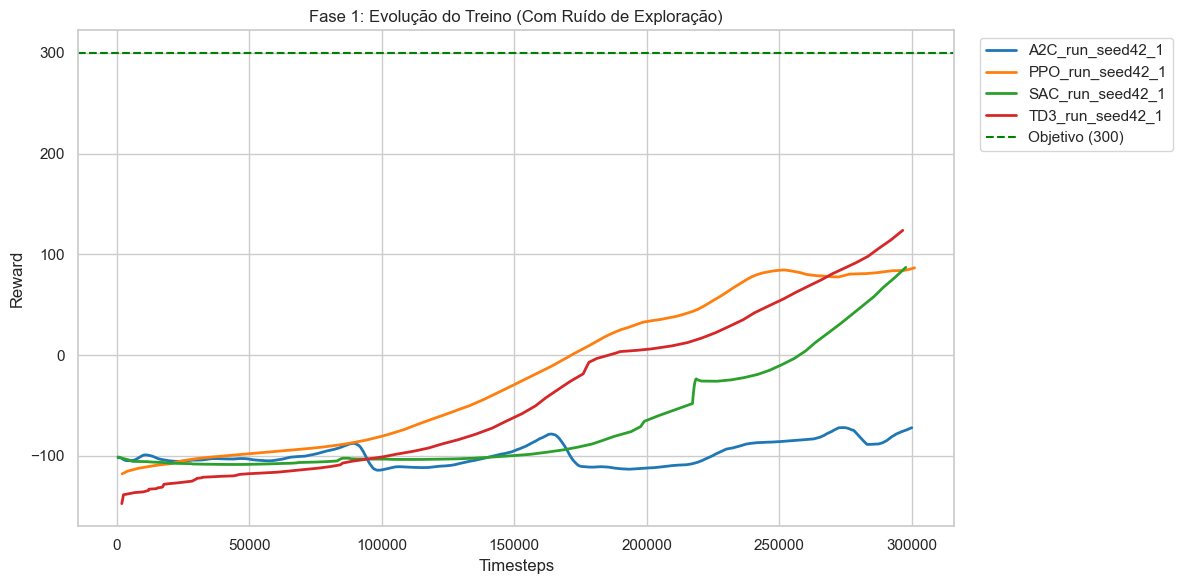

In [19]:
plot_training_curves(LOG_BASE, title="Fase 1: Evolução do Treino (Com Ruído de Exploração)")

#### Interpretação da curva de aprendizagem (Fase 1)

O gráfico anterior representa `rollout/ep_rew_mean`, ou seja, a **recompensa média por episódio durante o treino**. É importante notar que este sinal inclui **ruído de exploração** (e, em alguns algoritmos, ruído adicional nas ações), pelo que **não corresponde diretamente** ao desempenho final “puro” da política.

Ainda assim, a forma da curva é informativa para comparar, de forma qualitativa, **eficiência amostral**, **estabilidade** e **capacidade assintótica**:

- **A2C:** a curva mantém-se próxima de recompensas negativas durante grande parte do treino, sugerindo **aprendizagem insuficiente** no limite de passos considerado, ou necessidade de tuning mais cuidadoso para este ambiente.
- **PPO:** observa-se uma **subida relativamente rápida** no início, seguida de **abrandamento/plateau** e oscilações mais visíveis. Isto é compatível com um comportamento que aprende cedo mas pode tornar-se **sensível** a perturbações e a pequenas diferenças de trajetória.
- **SAC:** tende a demorar mais a sair do regime negativo, mas depois mostra **melhoria gradual**. Em contrapartida, a curva pode exibir **variância elevada**, sugerindo alternância entre episódios muito bons e episódios fracos durante o treino.
- **TD3:** apresenta a **tendência global mais consistente** (subida mais “limpa” e menos errática), o que é um bom indício de **estabilidade** e de um processo de aprendizagem menos vulnerável a flutuações.


--- FASE 1: AVALIAÇÃO DETERMINÍSTICA (SEM RUÍDO) ---
PPO: 253.12 +/- 71.82
SAC: 236.37 +/- 140.29
A2C: -83.20 +/- 6.57
TD3: 271.79 +/- 0.79


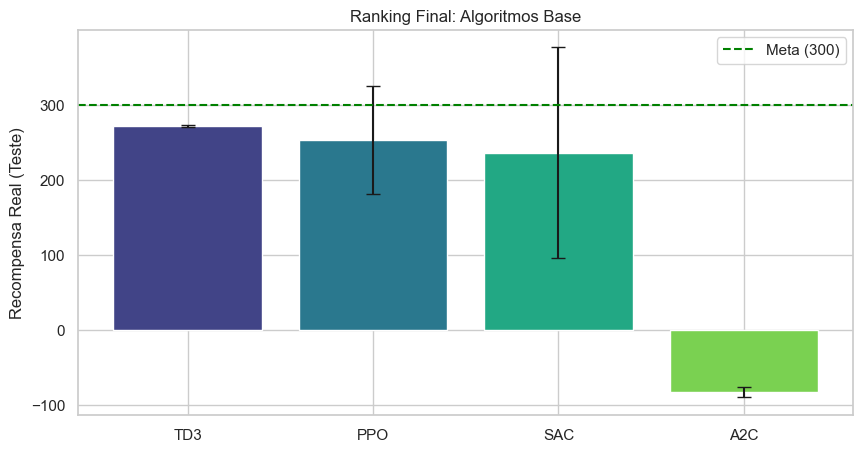

🏆 Vencedor da Fase 1: TD3


In [ ]:
results_phase1 = []

print("--- FASE 1: AVALIAÇÃO DETERMINÍSTICA (SEM RUÍDO) ---")

for name, AlgoClass in algos.items():
    path = f"{MODEL_BASE}/{name}_base.zip"
    mean, std = rigorous_eval(path, AlgoClass)
    
    if mean is not None:
        results_phase1.append({"Algoritmo": name, "Média": mean, "Std": std})
        print(f"{name}: {mean:.2f} +/- {std:.2f}")

# Gráfico Final da Seleção
df_p1 = pd.DataFrame(results_phase1).sort_values(by="Média", ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(df_p1["Algoritmo"], df_p1["Média"], yerr=df_p1["Std"], capsize=5, color=sns.color_palette("viridis", len(df_p1)))
plt.axhline(300, color="green", linestyle="--", label="Meta (300)")
plt.title("Ranking Final: Algoritmos Base")
plt.ylabel("Recompensa Real (Teste)")
plt.legend()
plt.show()

# Selecionar Vencedor Automaticamente
WINNER_NAME = df_p1.iloc[0]["Algoritmo"]
print(f"Vencedor da Fase 1: {WINNER_NAME}")

#### Análise da Fase 1 (avaliação determinística)

Nesta etapa, avaliámos cada política em modo **determinístico** (`deterministic=True`), isto é, **sem ruído de exploração**, durante **20 episódios** por algoritmo. O objetivo é medir o desempenho *real* e a **robustez** da política aprendida, usando a **média** e o **desvio‑padrão** como indicadores de qualidade e consistência.

- **TD3 (Twin Delayed DDPG):** apresentou o melhor compromisso entre desempenho e estabilidade, com **271.79 ± 0.79**. O desvio‑padrão extremamente baixo indica uma política muito consistente entre episódios (característica essencial para um *baseline* confiável).
- **PPO e SAC:** embora tenham mostrado desempenho médio competitivo, exibiram **dispersão considerável** entre episódios (no caso do SAC, com **Std na ordem de 140**), sugerindo políticas que alternam entre episódios muito bons e episódios claramente maus. Para o contexto do trabalho (comparação em ambiente “problemático”), esta variabilidade é indesejável porque introduz incerteza adicional na comparação.
- **A2C:** obteve um desempenho claramente insuficiente (**-83.20 ± 6.57**), confirmando que não convergiu para uma política competente no horizonte de treino utilizado.

**Decisão:** selecionamos o **TD3** como algoritmo *baseline* para a fase seguinte, por maximizar o retorno médio e, sobretudo, por minimizar a variância na avaliação determinística.


<a id="3"></a>
### 3. Fase 2: Otimização de Hiperparâmetros (Tuning)

Embora o TD3 tenha vencido, os hiperparâmetros padrão nem sempre são ideais. O algoritmo pode sofrer de instabilidade (aprender e depois esquecer).

Nesta fase, testamos três variantes do TD3 com **300.000 passos** e Seed fixa:

1.  **Baseline (LR=0.001):** A configuração padrão. É agressiva e pode ser instável.
2.  **Cauteloso (LR=0.0003):** Uma taxa de aprendizagem menor. Espera-se uma convergência mais lenta, mas mais sólida e com pontuação final mais alta.
3.  **Míope (Gamma=0.98):** Reduzimos o horizonte de planeamento para focar o agente no equilíbrio imediato.

In [ ]:
WinnerClass = algos[WINNER_NAME]
TIMESTEPS_PHASE2 = 300_000 

# Grid Search
configs = [
    {"lr": 0.001,  "gamma": 0.99, "name": "Baseline"},   
    {"lr": 0.0003, "gamma": 0.99, "name": "Cauteloso"},  
    {"lr": 0.001,  "gamma": 0.98, "name": "Miope"},      
]

print(f"--- FASE 2: TUNING DO {WINNER_NAME} (Seed {GLOBAL_SEED}) ---")

for conf in configs:
    run_id = f"{WINNER_NAME}_{conf['name']}"
    path_save = f"{MODEL_TUNING}/{run_id}"
    
    print(f"🔄 A treinar variante: {conf['name']} (LR={conf['lr']}, G={conf['gamma']})...")
    
    env = gym.make("BipedalWalker-v3")
    try:
        model = WinnerClass(
            "MlpPolicy", 
            env, 
            learning_rate=conf['lr'], 
            gamma=conf['gamma'], 
            seed=GLOBAL_SEED,    
            verbose=0, 
            tensorboard_log=LOG_TUNING
        )
        
        model.learn(total_timesteps=TIMESTEPS_PHASE2, tb_log_name=run_id)
        model.save(path_save)
        print(f"✅ {conf['name']} concluído.")
        
    except Exception as e: 
        print(f"❌ Erro: {e}")
    finally: 
        env.close()

--- FASE 2: TUNING DO TD3 (Seed 42) ---
🔄 A treinar variante: Baseline (LR=0.001, G=0.99)...
✅ Baseline concluído.
🔄 A treinar variante: Cauteloso (LR=0.0003, G=0.99)...
✅ Cauteloso concluído.
🔄 A treinar variante: Miope (LR=0.001, G=0.98)...
✅ Miope concluído.


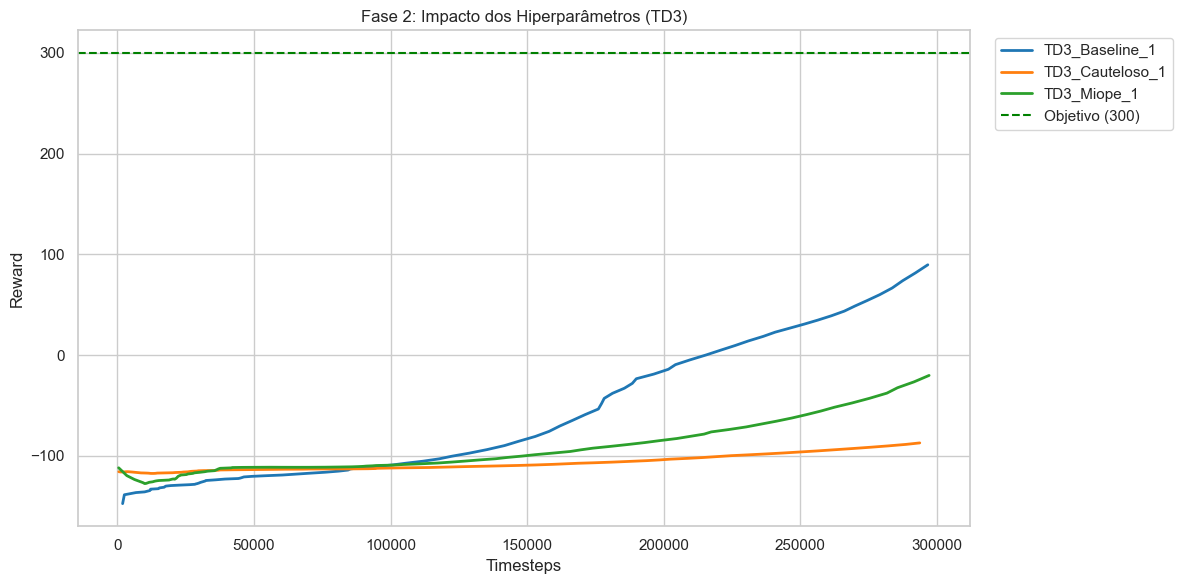

In [16]:
plot_training_curves(LOG_TUNING, title=f"Fase 2: Impacto dos Hiperparâmetros ({WINNER_NAME})", window=20)

#### Interpretação da curva de aprendizagem (Fase 2)

Na Fase 2, comparamos variantes do **TD3**. Tal como na Fase 1, a leitura das curvas (`rollout/ep_rew_mean`) deve ter em conta que estamos a observar um **sinal com ruído de exploração**, útil sobretudo para diagnóstico qualitativo (subida, plateau, oscilações, colapsos).

Com base na forma das curvas, é possível tirar as seguintes leituras:

- **LR baixa (Cauteloso):** a curva tende a evoluir lentamente e pode permanecer próxima de um plateau durante muito tempo, o que sugere **aprendizagem demasiado lenta** para o limite de passos usado (risco de *under-training*).
- **Baseline (gamma = 0.99):** pode mostrar ganhos mais rápidos, mas também **oscilações mais marcadas**, indiciando maior sensibilidade a variação de trajetórias e a estimativas do valor futuro (bootstrapping).
- **Míope (gamma = 0.98):** é comum observar uma evolução mais **regular** e com oscilações menos abruptas. Um `gamma` ligeiramente menor pode reduzir a dependência de retornos muito longos e **diminuir a variância** do alvo de treino, estabilizando a aprendizagem em certos ambientes.

In [ ]:
results_phase2 = []

print("--- FASE 2: AVALIAÇÃO FINAL ---")

for conf in configs:
    run_id = f"{WINNER_NAME}_{conf['name']}"
    path = f"{MODEL_TUNING}/{run_id}.zip"
    
    mean, std = rigorous_eval(path, WinnerClass, episodes=20) # 20 episódios para estatística sólida
    
    if mean is not None:
        results_phase2.append({"Config": conf['name'], "Média": mean, "Std": std, "Path": path})

df_p2 = pd.DataFrame(results_phase2).sort_values(by="Média", ascending=False)
display(df_p2)

# Guardar o caminho do melhor modelo para o Notebook 3
BEST_MODEL_PATH = df_p2.iloc[0]["Path"]
BEST_CONFIG_NAME = df_p2.iloc[0]["Config"]
print(f"MELHOR MODELO ABSOLUTO: {BEST_CONFIG_NAME} (Média: {df_p2.iloc[0]['Média']:.1f})")
print(f"Caminho: {BEST_MODEL_PATH}")

--- FASE 2: AVALIAÇÃO FINAL ---


,Config,Média,Std,Path
2,Miope,278.505737,1.695485,../models/tun_selection/TD3_Miope.zip
0,Baseline,254.212311,76.888695,../models/tun_selection/TD3_Baseline.zip
1,Cauteloso,-58.019966,15.599453,../models/tun_selection/TD3_Cauteloso.zip


MELHOR MODELO ABSOLUTO: Miope (Média: 278.5)
Caminho: ../models/tun_selection/TD3_Miope.zip


#### Análise dos Resultados do Tuning (avaliação determinística)

Para comparar as configurações do TD3, repetimos a metodologia de avaliação **determinística** (sem ruído) com **20 episódios** por configuração. Assim, a decisão baseia‑se em dois eixos: **desempenho médio** (qualidade) e **desvio‑padrão** (consistência).

1. **Configuração "Cauteloso" (LR mais baixa):** apresentou desempenho fraco (**-58.02 ± 15.60**). Apesar de relativamente estável, o retorno médio indica que a aprendizagem foi demasiado lenta para o limite de passos, levando a uma política final incapaz de resolver o ambiente de forma consistente.
2. **Configuração "Baseline" (LR=0.001, γ=0.99):** obteve uma média razoável (**254.21**), mas com **variância muito elevada** (**Std = 76.89**). Isto sugere uma política que, embora por vezes tenha episódios bons, falha com frequência (p.ex., quedas ou perda de controlo), o que reduz a fiabilidade do agente como referência.
3. **Configuração "Míope" (LR=0.001, γ=0.98):** foi claramente superior, combinando **a melhor média** (**278.51**) com **alta consistência** (**Std = 1.70**). Uma redução ligeira do *discount factor* pode ter tornado a aprendizagem mais estável (atribuição de crédito menos exigente), sem sacrificar o desempenho final.

**Conclusão:** a configuração **"Míope" (TD3, LR=0.001, γ=0.98)** é a escolha final para avançar para o ambiente problemático, por apresentar simultaneamente **alto retorno** e **baixa variância**.


<a id="4"></a>
### 4. Validação Final: Teste de Consistência

Uma média alta pode esconder falhas ocasionais. Para validar a robustez do nosso Campeão, executamos **50 episódios de teste consecutivos**.

* **O que procuramos:** Uma linha horizontal estável próxima dos 300 pontos.
* **O que rejeitamos:** Oscilações grandes (ex: ter 300 num episódio e -50 no seguinte).

A executar 50 episódios de teste de consistência...


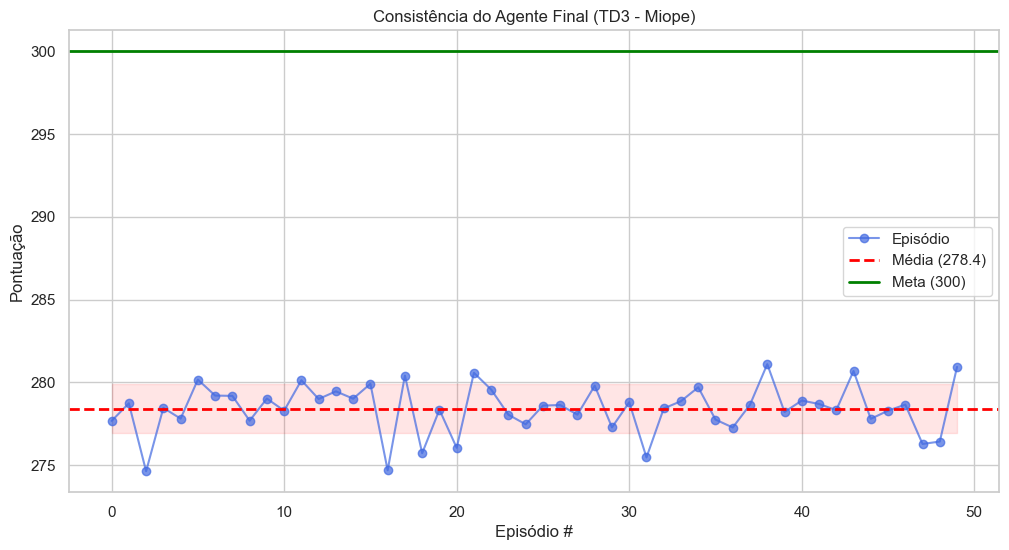

In [ ]:
def plot_consistency(model_path, AlgoClass, title):
    if not os.path.exists(model_path): return
    
    model = AlgoClass.load(model_path)
    env = gym.make("BipedalWalker-v3")
    
    scores = []
    print("A executar 50 episódios de teste de consistência...")
    for i in range(50):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, r, term, trunc, _ = env.step(action)
            total += r
            done = term or trunc
        scores.append(total)
    
    env.close()
    
    # Desenhar
    plt.figure(figsize=(12, 6))
    plt.plot(scores, marker='o', linestyle='-', color='royalblue', alpha=0.7, label="Episódio")
    plt.axhline(np.mean(scores), color='red', linestyle='--', linewidth=2, label=f"Média ({np.mean(scores):.1f})")
    plt.axhline(300, color='green', linestyle='-', linewidth=2, label="Meta (300)")
    plt.fill_between(range(50), np.mean(scores)-np.std(scores), np.mean(scores)+np.std(scores), color='red', alpha=0.1)
    
    plt.title(title)
    plt.xlabel("Episódio #")
    plt.ylabel("Pontuação")
    plt.legend()
    plt.show()

plot_consistency(BEST_MODEL_PATH, WinnerClass, f"Consistência do Agente Final ({WINNER_NAME} - {BEST_CONFIG_NAME})")

<a id="5"></a>
### 5. Conclusão e Próximos Passos

Este notebook consolidou uma **decisão metodologicamente justificada** para o baseline do trabalho: não basta maximizar a recompensa média; é crucial escolher uma política **estável e reprodutível**, de modo a que as diferenças observadas no ambiente “problemático” possam ser atribuídas à alteração do ambiente e não a flutuações do treino.

#### 5.1 Conclusões principais

1. **Seleção do Algoritmo (Fase 1):**  
   - O **TD3** foi o melhor candidato para o *BipedalWalker-v3* no limite de 300k passos, combinando **alto retorno** com **variância mínima** na avaliação determinística (≈ 271.8 ± 0.8).  
   - PPO e SAC obtiveram médias elevadas, mas com **desvios padrão muito altos**, indicando políticas menos robustas e menos adequadas como baseline.

2. **Tuning de Hiperparâmetros (Fase 2):**  
   - A configuração **“Míope”** (*LR=0.001, Gamma=0.98*) apresentou a melhor performance determinística e, sobretudo, **consistência** (≈ 278.5 ± 1.7).  
   - O **Baseline** (*Gamma=0.99*) mostrou-se instável (alta variância), e o **Cauteloso** (*LR=0.0003*) não aprendeu o suficiente no horizonte de treino.

3. **Validação de Consistência:**  
   - O teste com 50 episódios confirmou uma distribuição **concentrada** de pontuações em torno da média, reforçando que o agente final é um baseline fiável.

#### 5.2 Próximo passo (Notebook 03)

O modelo **TD3-Míope** será exportado como **baseline de robustez** e testado no ambiente “problemático” (p.ex., `InjuredBipedalWalker`), permitindo medir degradação de desempenho e identificar fragilidades do agente perante falhas mecânicas.
